Import required libraries

In [25]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import sys
flt_min = sys.float_info.min

%matplotlib inline

#### A)

Function used to load images

In [26]:
def load_img(img):
    files = glob.glob(img)
    ColorImgs = []
    for myFile in files:
        im = plt.imread(myFile)
        ColorImgs.append(im)
        
    return ColorImgs

Function to sort images loaded into datasets 'Apples' and 'nonApples'
+ 'Apples' contain the pixel RGB values that belong to apple
+ 'nonApples' contain the pixel RGB values that do not belong to apple

In [27]:
def img2dataset(original_imgs, mask_imgs):
    pixel_a = []
    pixel_na = []    
    # Look through all the pixels in all of the three mask images
    for k in range(len(mask_imgs)):
        for i in range(mask_imgs[k].shape[0]):
            for j in range(mask_imgs[k].shape[1]):
                if np.sum(mask_imgs[k][i, j][:3]) != 0:
                    pixel_a.append(original_imgs[k][i,j,:])
                else:
                    pixel_na.append(original_imgs[k][i,j,:])

    # Normalize the pixel values
    Apples = np.asarray(pixel_a).T/255  
    nonApples = np.asarray(pixel_na).T/255

    return Apples, nonApples

Load the raw images and mask images, separate the apple and not apple pixels, and store their RGB values in 'Data_A' and 'Data_NA'

In [28]:
original_imgs = load_img("apples/Apples_A*.jpg")
mask_imgs = load_img("Maskapples/MaskApples_A*.png") 

Data_A, Data_NA = img2dataset(original_imgs, mask_imgs)
# Verification
print(Data_A)  
print(Data_NA.shape)

[[0.9372549  0.9254902  0.89803922 ... 0.15686275 0.15294118 0.15294118]
 [0.78039216 0.76862745 0.7372549  ... 0.         0.         0.00392157]
 [0.67843137 0.63137255 0.61176471 ... 0.         0.         0.        ]]
(3, 370641)


------
#### B)

Returns the likelihood that each data point in data belongs to the Gaussian described by gaussMean and gaussCov

In [29]:
def calcGaussianProb(data,gaussMean,gaussCov):
    diff = data - gaussMean[:,None] 
    exponent = (-0.5) * np.sum((np.dot(diff.T,np.linalg.pinv(gaussCov))*diff.T),axis=1)
    norm_const = 1.0 /np.linalg.det(2 * np.pi * gaussCov)**(1/2)
    like = norm_const*np.exp(exponent)

    return like

By defalt(flag log is True) Calculate the log likelihood for the whole dataset under a mixture of Gaussians model.\
Otherwise(flag log is False) , return the likelihood for each data as an array.

In [30]:
def getMixGaussLike(data, mixGaussEst, log = True): 
                                                                
    nDims, nData = data.shape                                                                                                                                            
    lk = np.zeros((nData, ))       

    for k in range(mixGaussEst['k']): 
        lk = lk + mixGaussEst['weight'][k]*calcGaussianProb(data,mixGaussEst['mean'][:,k],mixGaussEst['cov'][:, :,k])

    if log == True:
        lk = sum(np.log(lk))
                                                                                            
    return  lk

Estimate a k MoG model that would fit the data.\
Iterate through E-M steps

In [31]:
def fitMixGauss(data, k):

    nDims, nData = data.shape
    postHidden = np.zeros(shape=(k, nData))
    lk = np.zeros(shape=(k, nData))

    # we will initialize the values to random values
    mixGaussEst = dict()
    mixGaussEst['d'] = nDims
    mixGaussEst['k'] = k
    mixGaussEst['weight'] = (1 / k) * np.ones(shape=(k))
    mixGaussEst['mean'] = 2 * np.random.randn(nDims, k)
    mixGaussEst['cov'] = np.zeros(shape=(nDims, nDims, k))
    for cGauss in range(k):
        mixGaussEst['cov'][:, :, cGauss] = 2.5 + 1.5 * np.random.uniform() * np.eye(nDims)
        
    # calculate the initial likelihood
    log_Like = []
    loglike_init = getMixGaussLike(data, mixGaussEst)
    log_Like.append(loglike_init)

    nIter = 150

    for cIter in range(nIter):

        # ===================== =====================
        # Expectation step
        # ===================== =====================

        for i in range(mixGaussEst['k']):    
            # lik = lamda_k * Norm_xi(mu_k,cov_k)                                                                                      
            lk[i] = mixGaussEst['weight'][i]*calcGaussianProb(data, mixGaussEst['mean'][:, i], mixGaussEst['cov'][:,:,i])

        # r_ik = like/ sum_k(like)
        postHidden = lk/np.sum(lk, axis=0)
        

        # ===================== =====================
        # Maximization Step
        # ===================== =====================
        # for each constituent Gaussian
        for cGauss in range(k):
            # Update weighting parameters mixGauss.weight based on the total
            # posterior probability associated with each Gaussian.
            mixGaussEst['weight'][cGauss] = np.sum(postHidden[cGauss, :])/np.sum(postHidden)
            
            
            # Update mean parameters mixGauss.mean by weighted average
            # where weights are given by posterior probability associated with
            # Gaussian.
            mixGaussEst['mean'][:,cGauss] = np.dot(data, postHidden[cGauss, :]) / np.sum(postHidden[cGauss, :])
            
            
            # Update covarance parameter based on weighted average of
            # square distance from update mean, where weights are given by
            # posterior probability associated with Gaussian
            diff = data - mixGaussEst['mean'][:, cGauss].reshape(nDims,1)
            mixGaussEst['cov'][:,:,cGauss] = (postHidden[cGauss,:]*diff)@diff.T / np.sum(postHidden[cGauss, :])
            
            
        # calculate the log likelihood
        loglike = getMixGaussLike(data, mixGaussEst)
        
        log_Like.append(loglike)

        # When the log likelihood does not change much, stop the iteration
        if(abs(log_Like[cIter] - log_Like[cIter+1]) < 1):
             break
    
    print('Log Likelihood After Iter {} : {:4.3f}\n'.format(cIter, log_Like[cIter]))

    return mixGaussEst, log_Like 

Function used to compute the BIC (Bayesian information criterion) for a given model.

In [32]:
'''
def BIC(likelihood,data,k):
    nDim, nData = data.shape
    K = k * (nDim  +nDim*(nDim + 1)/2)+ (k-1)
    BIC = -2*np.log(likelihood[-1]) + K*np.log(nData)
    print('The BIC of the model when k = {}: {:4.3f}\n'.format(k, BIC))
    
    return BIC
'''

"\ndef BIC(likelihood,data,k):\n    nDim, nData = data.shape\n    K = k * (nDim  +nDim*(nDim + 1)/2)+ (k-1)\n    BIC = -2*np.log(likelihood[-1]) + K*np.log(nData)\n    print('The BIC of the model when k = {}: {:4.3f}\n'.format(k, BIC))\n    \n    return BIC\n"

Generate the MOG model for each dataset. When k = 2

In [33]:
MixGaussEst_A2,log_Like_A2 = fitMixGauss(Data_A,2)
MixGaussEst_NA2,log_Like_NA2 = fitMixGauss(Data_NA,2)

Log Likelihood After Iter 49 : 565354.528

Log Likelihood After Iter 36 : 614167.282



Generate the MOG model for each dataset. When k = 3

In [34]:
'''
MixGaussEst_A3,log_Like_A3 = fitMixGauss(Data_A,3)
MixGaussEst_NA3,log_Like_NA3 = fitMixGauss(Data_NA,3)
'''

'\nMixGaussEst_A3,log_Like_A3 = fitMixGauss(Data_A,3)\nMixGaussEst_NA3,log_Like_NA3 = fitMixGauss(Data_NA,3)\n'

Generate the MOG model for each dataset. When k = 4

In [35]:
'''
MixGaussEst_A4,log_Like_A4 = fitMixGauss(Data_A,4)
MixGaussEst_NA4,log_Like_NA4 = fitMixGauss(Data_NA,4)
'''

'\nMixGaussEst_A4,log_Like_A4 = fitMixGauss(Data_A,4)\nMixGaussEst_NA4,log_Like_NA4 = fitMixGauss(Data_NA,4)\n'

Compare the BIC of model pairs with different k, the pair of models with least BIC is preferred

In [36]:
'''
BIC_A2 = BIC(log_Like_A2, Data_A,2)
BIC_NA2 = BIC(log_Like_NA2, Data_NA, 2)
BIC_A3 = BIC(log_Like_A3, Data_A, 3)
BIC_NA3 = BIC(log_Like_NA3, Data_NA, 3)
BIC_A4 = BIC(log_Like_A4, Data_A, 4)
BIC_NA4 = BIC(log_Like_NA4, Data_NA, 4)
'''

'\nBIC_A2 = BIC(log_Like_A2, Data_A,2)\nBIC_NA2 = BIC(log_Like_NA2, Data_NA, 2)\nBIC_A3 = BIC(log_Like_A3, Data_A, 3)\nBIC_NA3 = BIC(log_Like_NA3, Data_NA, 3)\nBIC_A4 = BIC(log_Like_A4, Data_A, 4)\nBIC_NA4 = BIC(log_Like_NA4, Data_NA, 4)\n'

By comparing the BIC of the models with different k, $k = 2$ gives the minimum BIC, therefore $k$ is set to 2. Plot the log likelihood of each dataset w.r.t its model with each iteration 

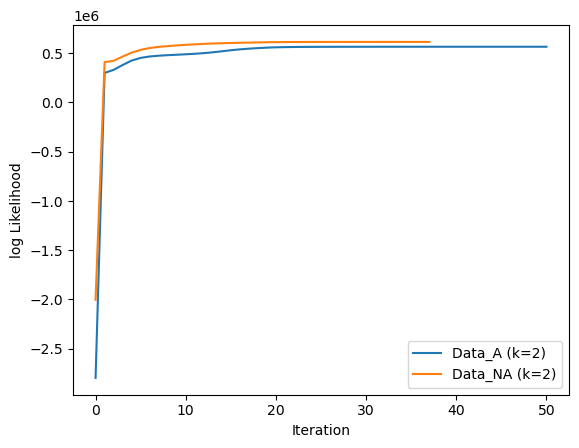

In [37]:
plt.plot(log_Like_A2, label= 'Data_A (k=2)')
plt.plot(log_Like_NA2, label= 'Data_NA (k=2)')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('log Likelihood')
plt.show()

By trying different numbers of Gaussian combinations, the BIC result when $k$ = 2 is the smallest, which is preferred. It adds a penalty for the number of parameters to see if the improvement in likelihood is worth it. If the number of clusters(parameters) is too large, the model will catch too many details of the training data and induce noise, resulting in poor performance on test data.\
The images show that given the estimated model, the likelihood of the data increases and converges after certain iterations, which means the the data fits well with the trained model eventually.

------
#### C)

Function to calculate poserior of images based on given priors.

In [38]:
def posterior(image, prior_A, prior_NA):

    Posterior = []
    for i in range(len(image)):

        imY, imX, imZ = image[i].shape

        # Reshape and normalize image
        reshaped_img = image[i].reshape(imY*imX,imZ).T/255 

        # calculate MOG likelihood
        like_A = getMixGaussLike(reshaped_img, MixGaussEst_A2, log = False)
        like_NA = getMixGaussLike(reshaped_img, MixGaussEst_NA2, log = False)

        # Calculate the posterior
        posterior = (like_A*prior_A)/(like_A*prior_A+like_NA*prior_NA)

        # Reshape posterior to original image shape
        reshaped_posterior = posterior.reshape(imY, imX)

        Posterior.append(reshaped_posterior)
            
    return Posterior

Load the test images, calculate the prior of pixels being apple, calculate the posterior, and plot the result.

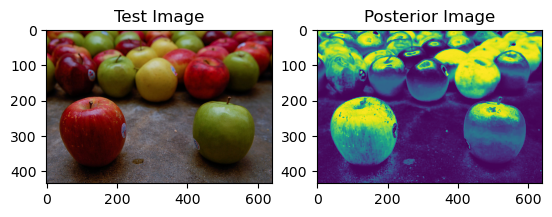

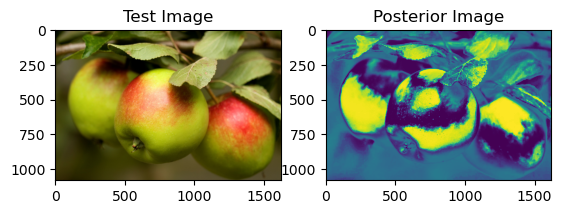

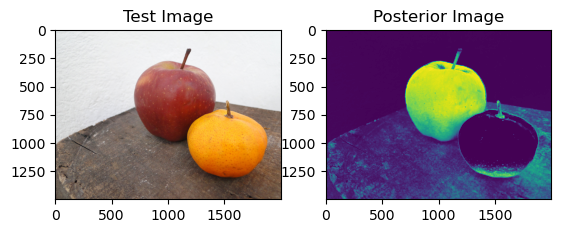

In [39]:
test_imgs = load_img("Apples/Apples_C*.jpg")

# An estimate of the proportion of apple pixels
prior_A = Data_A.shape[1]/(Data_A.shape[1]+Data_NA.shape[1])
prior_NA = 1 - prior_A
posterior_A = posterior(test_imgs, prior_A, prior_NA)

# display the test images and the posterior images
for i in range(len(test_imgs)):
    _, (ax1, ax2) = plt.subplots(1, 2)
    ax1.set_title('Test Image')
    ax1.imshow(test_imgs[i])
    ax2.set_title('Posterior Image')
    ax2.imshow(posterior_A[i])
    
    
plt.show()

The images above show the original test images with their posterior images. The posterior result highlights the pixels estimated to be apples, which matches the expectation.\
However, the result shows some unsuccessful recognition due to a lack of training data, such as the yellow apples in the first image and the mixed colour part in the second image. In terms of the third image, the bottom of the orange is highlighted as an apple as well, probably because the RGB values are similar to apple pixels due to the dark light.\
With a larger training dataset that contains more comprehensive scenarios, such as different light conditions, and species of apples, the performance of the model is likely to be improved. Also, inducing joint probability between apple pixels and their neighbour pixels may increase the performance for images like image 2.

------
#### D)

Function used to apply the threshold to the posterior image. For each pixel in the image, set its value to 0 if it is less than the threshold, and to 1 otherwise.

In [40]:
def threshold_posterior(img, threshold):
     nDim,nData = img.shape
     img_threshed = img.copy()
     for i in range(nDim):
          for j in range(nData):
               if img_threshed[i,j] < threshold:
                    img_threshed[i,j]=0
               else:
                    img_threshed[i,j]=1

     return img_threshed

For each threshold, calculate the TPR, and FPR of the pixels, and calculate the distance between (fpr, tpr) and （0, 1）
The threshold minimizing the distance is the optimal one.

In [41]:
def ROC_curve(posterior, mask, threshold):
    ROC = np.zeros((2,len(threshold)))
    distance = np.zeros(len(threshold))
    nDim,nData = posterior.shape
    
    # Iterate through the give threshold array
    for idx, i in enumerate(threshold):

        # initialise the parameters
        TP = 0
        TN = 0
        FP = 0
        FN = 0

        # Iterate through all the pixels
        for x in range(nDim):  
            for y in range(nData):        
                if((mask[x, y] == 1) and (posterior[x, y] >= i)):
                    TP += 1
                elif ((mask[x, y] == 0) and (posterior[x, y] < i)):
                    TN += 1                    
                elif ((mask[x, y] == 1) and (posterior[x, y] < i)):
                    FP += 1
                elif ((mask[x, y] == 0) and (posterior[x, y] >= i)):
                    FN += 1

        if (TP+FN) == 0:
            tpr = 0
        else:
            tpr = TP/(TP+FN)    # true positive rate)

        if (FP+TN) == 0:
            fpr = 0
        else:
            fpr = FP/(FP+TN)    # false positive rate
            
        # Calculate the distance between each point on the curve and (0,1)
        distance[idx] = np.sqrt((fpr - 0)**2 + (tpr - 1)**2)
        ROC[0,idx] = tpr
        ROC[1,idx] = fpr 
        
    Optimal_threshold = threshold[np.argmin(distance)]

    return ROC, Optimal_threshold

Import the ground truth mask, plot the ROC curve, and locate the optimal threshold.

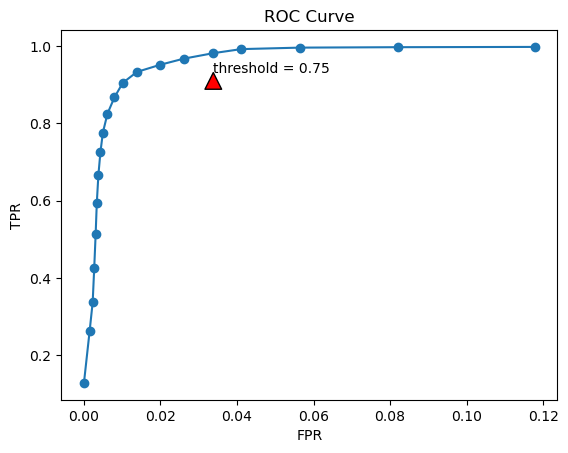

In [42]:
Ground_truth_D = load_img('Maskapples/Apples_D.png') #Load the image
Data_GT_D = Ground_truth_D[0][:,:,0]
threshold = np.arange(0,1,0.05)     # Define the threshold range
ROC, Optimal_threshold = ROC_curve(posterior_A[2], Data_GT_D, threshold)

# Plot the ROC curve with the optimal threshold marked
plt.title('ROC Curve')
plt.plot(ROC[1,:], ROC[0,:], '-o')
plt.xlabel('FPR')
plt.ylabel('TPR')

threshold_index = np.where(threshold == Optimal_threshold)
plt.annotate('threshold = {:.2f}'.format(Optimal_threshold), xy=(ROC[1,threshold_index], ROC[0,threshold_index]-0.05),arrowprops=dict(facecolor='red', shrink=0.03))

plt.show()

The ROC curve is closed to (0, 1), indicating that the performance of the model has low FPR and high TPR. As the threshold increases, the TPR approaches 1 and the FPR is slightly increased. By looking for the point with the minimum distance to (0, 1), the optimal threshold of 0.75 is determined.

Apply the optimal threshold on the posterior image, and show it with the mask and the posterior images.

Text(0.5, 1.0, 'Threshold = 0.75')

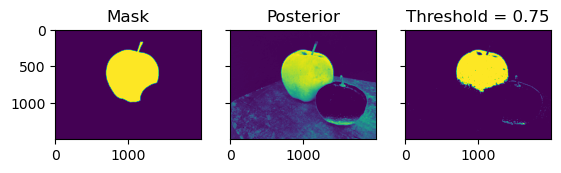

In [43]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey='row')

# show the mask
ax1.imshow(Data_GT_D)
ax1.set_title('Mask')

# show the posterior
ax2.imshow(posterior_A[2])
ax2.set_title('Posterior')

# show the thresholded image
ax3.imshow(threshold_posterior(posterior_A[2], Optimal_threshold))
ax3.set_title('Threshold = {:.2f}'.format(Optimal_threshold))

------
#### E)

Load the two test images, compute their posterior, and display them.

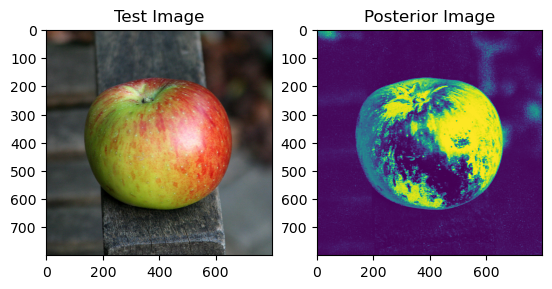

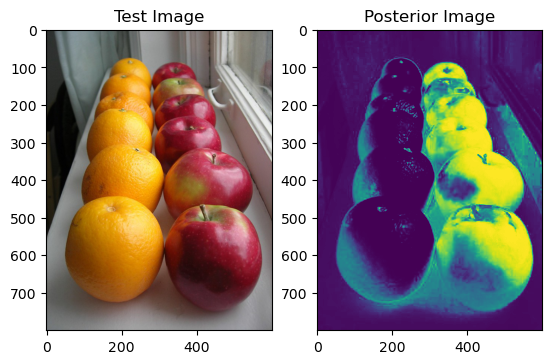

In [44]:
test_imgs_E = load_img("Apples/Apples_E*.jpg")
posterior_A_E = posterior(test_imgs_E, prior_A, prior_NA)
for i in range(len(test_imgs_E)):
    _, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(test_imgs_E[i])
    ax1.set_title('Test Image')
    ax2.imshow(posterior_A_E[i])
    ax2.set_title('Posterior Image')
    
plt.show()

Apples in the raw images are highlighted in the posterior images as expected. However, the green part of the apple in the first image is not recognized well, a similar issue occurs in the second image as well. Besides, in the first posterior image, part of the background in orange is regarded as apples. In image 2, the intersection area of the oranges and the apples is also seen as an apple, and this also happens in the shadow of the window border. These flaws also happened with the test images in section C, reflecting the diversity lack of the training data.

The code below loads the ground-truth mask of the image Myapple1.jpg, and uses it to generate the ROC curve with respect to different thresholds, and find the optimal threshold.

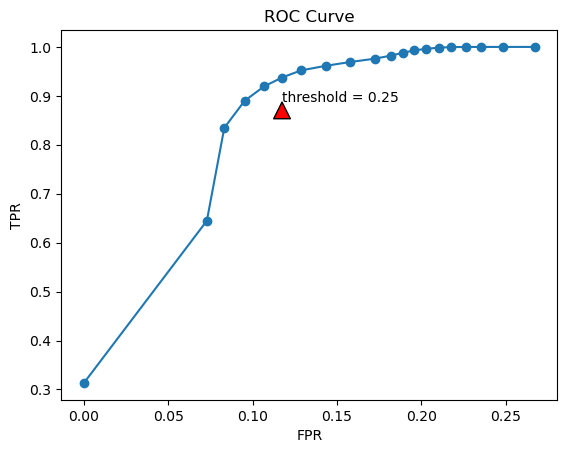

In [45]:
Ground_truth_E1 = load_img('Maskapples/MaskApples_E1.png') #Load the mask
Data_GT_E1 = Ground_truth_E1[0]

ROC_E1, Optimal_threshold_E1 = ROC_curve(posterior_A_E[0], Data_GT_E1, threshold)

# Plot the ROC curve with the optimal threshold marked
plt.title('ROC Curve')
plt.plot(ROC_E1[1,:], ROC_E1[0,:], '-o')
plt.xlabel('FPR')
plt.ylabel('TPR')

threshold_index_E1 = np.where(threshold == Optimal_threshold_E1)
plt.annotate('threshold = {:.2f}'.format(Optimal_threshold_E1), xy=(ROC_E1[1,threshold_index_E1], ROC_E1[0,threshold_index_E1]-0.05),arrowprops=dict(facecolor='red', shrink=0.03))

plt.show()

The curve above shows that the performance of the model is not as good as before. As the threshold increases, the FPR increases faster, resulting in the curve deviating from the point (0, 1). The optimal threshold is 0.25, whose corresponding point on the curve is closest to the point (0,1).

The code below plots the original image, the ground truth image, the posterior image, and the thresholded image.

Text(0.5, 1.0, 'Threshold = 0.25')

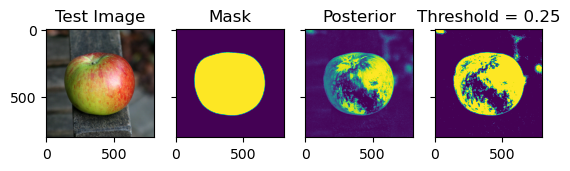

In [46]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey='row')

# show the original image
ax1.imshow(test_imgs_E[0])
ax1.set_title('Test Image')

# show the mask
ax2.imshow(Data_GT_E1)
ax2.set_title('Mask')

# show the prediction
ax3.imshow(posterior_A_E[0])
ax3.set_title('Posterior')

# show the thresholded image
ax4.imshow(threshold_posterior(posterior_A_E[0], Optimal_threshold_E1))
ax4.set_title('Threshold = {:.2f}'.format(Optimal_threshold_E1))

As shown in the figures above, although most of the apple is highlighted, the green part in the middle of the apple is not successfully recognized, and some background is incorrectly seen as apple. 

The code below plots the ROC curve of the second test image.

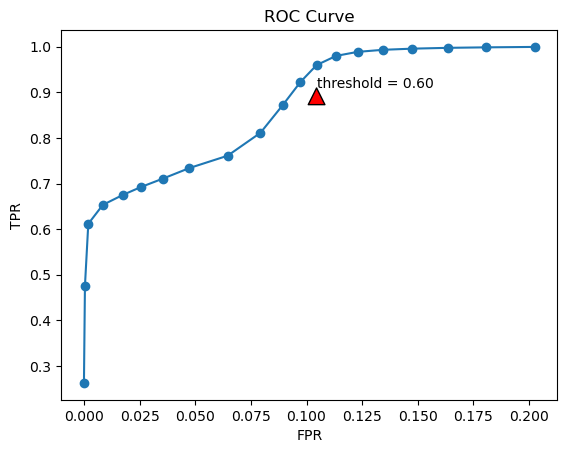

In [47]:
Ground_truth_E2 = load_img('Maskapples/MaskApples_E2.png') #Load the image
Data_GT_E2 = Ground_truth_E2[0]

ROC_E2, Optimal_threshold_E2 = ROC_curve(posterior_A_E[1], Data_GT_E2, threshold)

# Plot the ROC curve with the optimal threshold marked
plt.title('ROC Curve')
plt.plot(ROC_E2[1,:], ROC_E2[0,:], '-o')
plt.xlabel('FPR')
plt.ylabel('TPR')

threshold_index_E2 = np.where(threshold == Optimal_threshold_E2)
plt.annotate('threshold = {:.2f}'.format(Optimal_threshold_E2), xy=(ROC_E2[1,threshold_index_E2], ROC_E2[0,threshold_index_E2]-0.05),arrowprops=dict(facecolor='red', shrink=0.03))

plt.show()

With the optimal threshold at 0.6, the TPR is over 90% and the FPR is around 10%. The curve is close to the point (0, 1), indicating the model performs well.

The code below plots the original image, the ground truth image, the posterior image, and the thresholded image.

Text(0.5, 1.0, 'Threshold = 0.60')

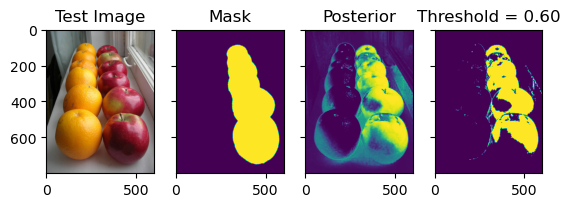

In [48]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey='row')

# show the original image
ax1.imshow(test_imgs_E[1])
ax1.set_title('Test Image')

# show the mask
ax2.imshow(Data_GT_E2)
ax2.set_title('Mask')

# show the prediction
ax3.imshow(posterior_A_E[1])
ax3.set_title('Posterior')

# show the thresholded image
ax4.imshow(threshold_posterior(posterior_A_E[1], Optimal_threshold_E2))
ax4.set_title('Threshold = {:.2f}'.format(Optimal_threshold_E2))

With the threshold applied, the oranges and the window border almost disappeared. However, the green part and dark part in the apple are removed incorrectly since their pixel values are not high enough. 

------
#### F)

When training the Mixture of Gaussian model, the number of Gaussian model $k$, is chosen as 2 based on the Bayesian Information Criterion (BIC). It is a technique with certain references, but it is better to do cross-validation.\
For the MOG model, $k$ is a hyperparameter, which can not be optimized during the training procedure. Therefore, after the model parameters are obtained using the training set, a separate set of files is needed as the validation set, which is used to tune the hyperparameters like the $k$. After the cross-validation, another separated set is used as the test set to evaluate the final performance of the model on unseen data. 